In [1]:
#I just keep making this list longer
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from scipy.stats.mstats import winsorize

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
ufc_df = pd.read_csv('/Users/richardlafferty/Downloads/ufcdata/preprocessed_data.csv')

In [3]:
print(ufc_df.head())

  Winner  title_bout  no_of_rounds  B_current_lose_streak  \
0    Red        True             5                  0.000   
1    Red        True             5                  0.000   
2    Red       False             3                  0.000   
3   Blue       False             3                  0.000   
4   Blue       False             3                  0.000   

   B_current_win_streak  B_draw  B_avg_BODY_att  B_avg_BODY_landed  \
0                 4.000   0.000           9.200              6.000   
1                 3.000   0.000          14.600              9.100   
2                 3.000   0.000          15.355             11.323   
3                 4.000   0.000          17.000             14.000   
4                 1.000   0.000          17.000             14.500   

   B_avg_CLINCH_att  B_avg_CLINCH_landed  ...  \
0             0.200                0.000  ...   
1            11.800                7.300  ...   
2             6.742                4.387  ...   
3            13.

In [4]:
print(ufc_df.isnull().sum())
print(ufc_df.columns)
print(ufc_df.info())


Winner                                0
title_bout                            0
no_of_rounds                          0
B_current_lose_streak                 0
B_current_win_streak                  0
B_draw                                0
B_avg_BODY_att                        0
B_avg_BODY_landed                     0
B_avg_CLINCH_att                      0
B_avg_CLINCH_landed                   0
B_avg_DISTANCE_att                    0
B_avg_DISTANCE_landed                 0
B_avg_GROUND_att                      0
B_avg_GROUND_landed                   0
B_avg_HEAD_att                        0
B_avg_HEAD_landed                     0
B_avg_KD                              0
B_avg_LEG_att                         0
B_avg_LEG_landed                      0
B_avg_PASS                            0
B_avg_REV                             0
B_avg_SIG_STR_att                     0
B_avg_SIG_STR_landed                  0
B_avg_SIG_STR_pct                     0
B_avg_SUB_ATT                         0


In [5]:
#we only have one boolean and one object so let's just get dummies and get on with it
#the preprocessed data looks to have been done very well
ufc_df = pd.get_dummies(ufc_df)
ufc_df = ufc_df.dropna()

In [6]:
print(ufc_df.tail())

      title_bout  no_of_rounds  B_current_lose_streak  B_current_win_streak  \
3587       False             1                  0.000                 1.000   
3588       False             1                  0.000                 1.000   
3589        True             1                  0.000                 2.000   
3590       False             1                  0.000                 1.000   
3591       False             1                  0.000                 1.000   

      B_draw  B_avg_BODY_att  B_avg_BODY_landed  B_avg_CLINCH_att  \
3587   0.000           1.000              1.000             0.000   
3588   0.000           0.000              0.000             1.000   
3589   0.000           0.500              0.500             0.000   
3590   0.000           0.000              0.000             0.000   
3591   0.000           4.000              3.000             9.000   

      B_avg_CLINCH_landed  B_avg_DISTANCE_att  ...  B_Stance_Orthodox  \
3587                0.000            

### What's fun about this data set is that there a lot of variables that could easily be features. Although I've only been doing this for a while, this problem screams "Random Forest" at me.

In [7]:
# now let's see what makes a winner for red 
print(ufc_df.iloc[:, :].corr().loc[:, 'Winner_Red'].sort_values(ascending=False))

Winner_Red                        1.000
R_avg_TD_pct                      0.105
R_avg_GROUND_att                  0.090
title_bout                        0.090
R_avg_SIG_STR_pct                 0.081
R_Weight_lbs                      0.081
B_total_title_bouts               0.078
R_avg_GROUND_landed               0.076
B_age                             0.076
B_Weight_lbs                      0.073
weight_class_Open Weight          0.071
R_avg_PASS                        0.071
R_avg_TD_landed                   0.067
B_avg_opp_GROUND_att              0.061
R_current_win_streak              0.060
R_Reach_cms                       0.059
B_avg_opp_TD_pct                  0.059
R_avg_SUB_ATT                     0.059
R_Height_cms                      0.055
B_avg_opp_GROUND_landed           0.051
B_avg_opp_SUB_ATT                 0.050
B_avg_opp_SIG_STR_pct             0.049
B_win_by_TKO_Doctor_Stoppage      0.046
B_avg_SUB_ATT                     0.045
R_total_title_bouts               0.038


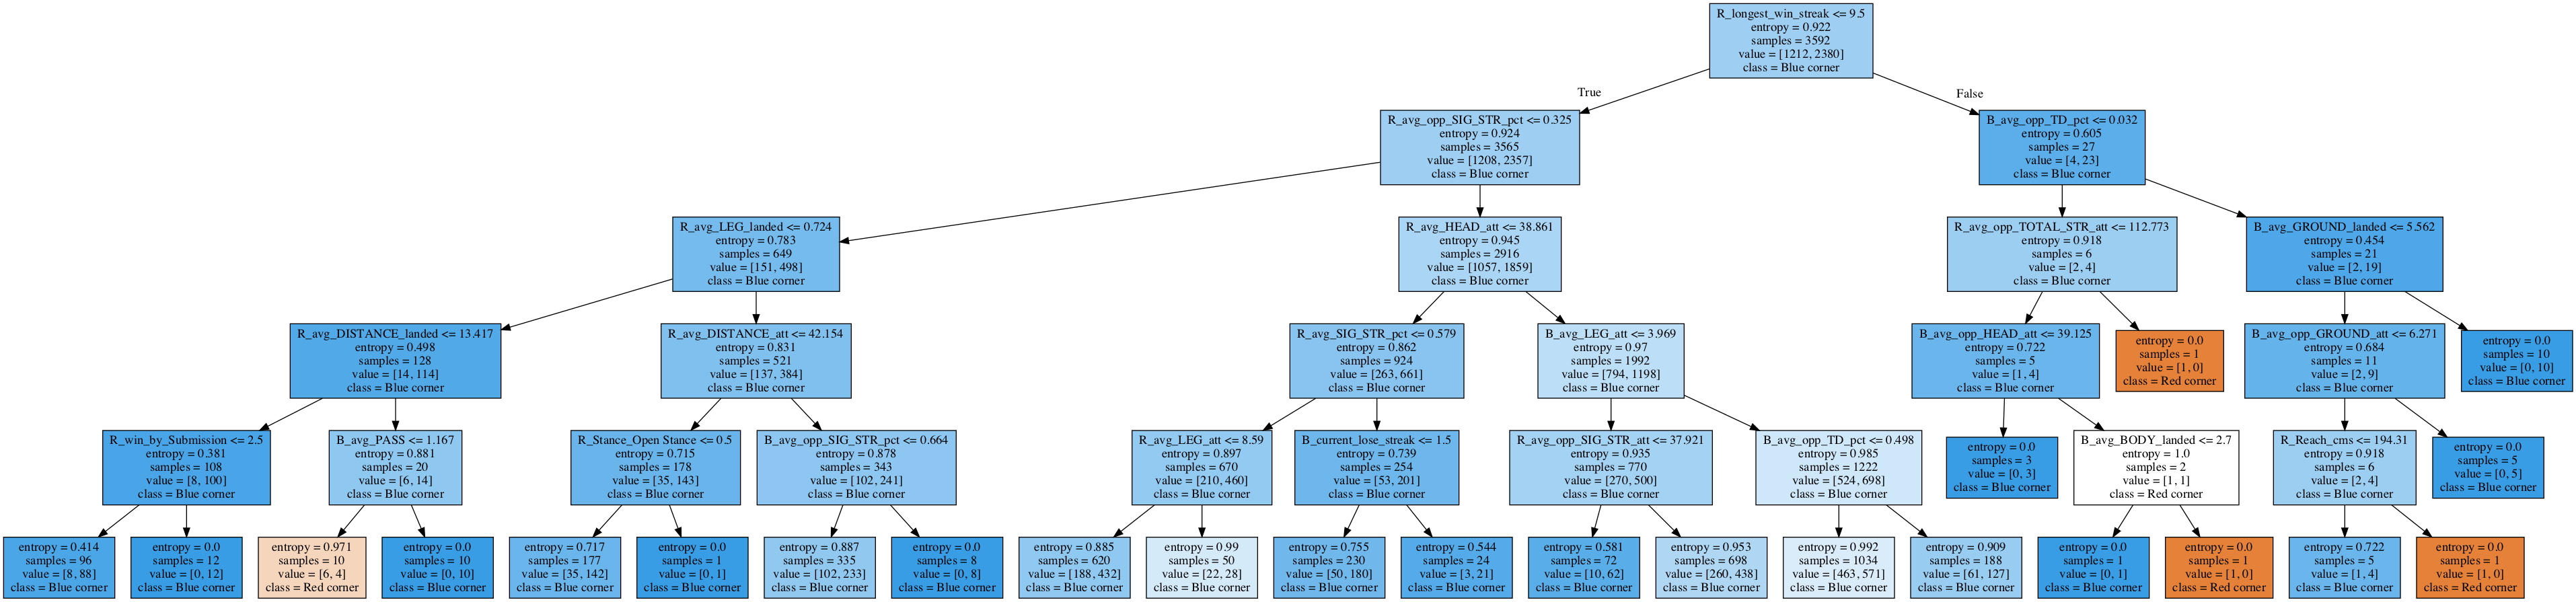

<Figure size 10800x3600 with 0 Axes>

In [25]:
#so we have 161 variables to look at. I think we will look at Winner Red 
#as our target variable. A decision tree and random forest model will hoprfully work 
#well with so many variables 
# This is the model we'll be using.
#we need a new DF for making our tree. I will be using the winner red
ufc_red = ufc_df.Winner_Red
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

# Initialize and train our tree.
# no random state
# make a larger figure
plt.figure(figsize=(150,50))
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=5
)
decision_tree.fit(ufc_df, ufc_red)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=ufc_df.columns,
    class_names=['Red corner', 'Blue corner'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())


In [26]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = ufc_df.drop('Winner_Red', 1)
Y = ufc_df['Winner_Red']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([0.975     , 1.        , 0.99164345, 0.9637883 , 0.99442897,
       0.97214485, 0.98885794, 0.99164345, 0.99721448, 0.97771588])

In [32]:
import atexit
from time import time, strftime, localtime
from datetime import timedelta

def secondsToStr(elapsed=None):
    if elapsed is None:
        return strftime("%Y-%m-%d %H:%M:%S", localtime())
    else:
        return str(timedelta(seconds=elapsed))

def log(s, elapsed=None):
    line = "="*40
    print(line)
    print(secondsToStr(), '-', s)
    if elapsed:
        print("Elapsed time:", elapsed)
    print(line)
    print()

def endlog():
    end = time()
    elapsed = end-start
    log("End Program", secondsToStr(elapsed))

start = time()
atexit.register(endlog)
log('decision tree', decision_tree.fit(ufc_df, ufc_red))
endlog()


2019-11-25 09:36:06 - decision tree
Elapsed time: DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

2019-11-25 09:36:06 - End Program
Elapsed time: 0:00:00.052877



In [34]:
start = time()
atexit.register(endlog)
log('rfc', rfc.fit(X,Y))
endlog()


2019-11-25 09:46:16 - rfc
Elapsed time: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

2019-11-25 09:46:16 - End Program
Elapsed time: 0:00:00.158272



## The random forest model takes almost three times as long to run as the decision tree. In this case it really doesn't matter but I could see the potential pitfalls of using a random forest model